In [1]:
import numpy as np

import fourth_day
from organism import Organism
from camera_visualisation import CameraVisualisation
from fourth_day_interface import InterfaceFourthDay


---

### Simulate the organisms with the fourth_day package

First, change any settings in the simulation to fit it to your requirements. To simulate images like those taken by the cameras in straw-b, I used the following adaptions (the duration of the simulation is longer than the exposure time of the cameras so that organisms are visible on the virtually created image):

In [12]:
fourth_day.config['scenario'] = {
    'class':'New',                  # Scenario Class - New: Run a new Monte Carlo simulation. Statistics are saved
    "statistics storage": {         # Save and load string
            "store": False,
            "location": "../data/statistics/",
            "name": "example_run_1"
        },
    "premature break": True,        # Break when no organisms in volume
    "duration": 120,                 # Length of simulation in seconds
    "population size": 100,          # The population
    "inital distribution": "Uniform",# Starting distribution -Uniform: Organisms are randomly distributed at the beginning
    "injection": {                  # Injection rate
        "rate": 3e-1,               # Number of organisms to inject per second
        "y range": [0., 15.],       # The injection is treated as a binomial distro with p=0.5 for rate >= 1, else rate = p
    },                              
    "exclusion": True,              # If an exclusion zone should be used
    "bounce back": 0.001,           # Bounce back
    "encounters": True,            # Encounters on / off
    "organism movement": True,     # Switch for organisms movement
    "detector" : {                  # The detector
        "switch": True,
        "type": "PMTSpec",
        "response": True,
        "acceptance": "Flat",
        "mean detection prob": 1
    },
    'light prop': {
        'switch': False,
        'x_pos': 3,
        'y_pos': 0.5 * 15. - 0.15
    },
    'detection type': 'Flat'
}

x_length = 30.
y_length = 15.

# Geometry
# These settings define the geometry of the system
# Typically a box (simulation volume) with a spherical exclusion zone (detector)
fourth_day.config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': x_length,
    'y_length': y_length,
    'offset': None,
}
# Reduce the observation size to reduce the computational load
fourth_day.config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': x_length,
    'y_length': y_length,
    "offset": np.array([0., 0.]),
}
# The detector volume
fourth_day.config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.042,  # diameter of the straw-b cable: 8.4 mm
    "x_pos": 3.,
    "y_pos": 0.5 * y_length,
}

# Organisms
fourth_day.config['organisms']["minimal shear stress"] = 0.005
fourth_day.config['organisms']['filter'] = 'depth'
fourth_day.config['organisms']['depth filter'] = 1500

#fourth_day.config["general"]["random state seed"] = 10

In [13]:
# to get different initial states, use different seeds for the random number generator 
fourth_day.config["general"]["random state seed"] = np.random.randint(0, 2**32 - 1)

# simulate 
fd = fourth_day.Fourth_Day()
fd.sim()

In [14]:
# use interface class to get extract the properties for each simulated organism

interface = InterfaceFourthDay(fourthday=fd, cam_device_code='TUMPMTSPECTROMETER001', z_min=0, z_max=10)
all_orgs = interface.org_df()  # list of dataframes of which each is describing one organism
characteristics = interface.characteristics()  # some characteristics of the organisms

---

### Example: Visualize one organism

In [16]:
# choose your organism (the one with the longest dataframe in all_orgs might be a good choice 
# to see the organism on the image)

index = 1

In [17]:
# get the properties of our chosen organism
positions = np.array([all_orgs[index].x_sim, all_orgs[index].y_sim, all_orgs[index].z_sim])
intensity = all_orgs[index].photons 
species = characteristics[1][index]
radius = characteristics[2][index]
mean_emission = characteristics[3][index]
sd_mean = characteristics[4][index]

In [18]:
# convert the trajectory of the organism
org = Organism(species=species, radius=radius, positions=positions, mean_emission=mean_emission,
                      sd_mean_emission=sd_mean, intensity=intensity)

int_pdf = org.intensity_pdf(n_times=1000)
traj_interp = org.points_along_trajectory(times=int_pdf[1])
final_points = org.points_along_trajectory_on_organism_surface(points=traj_interp[0], 
                                                               trajectory_interp_xy=traj_interp[1], 
                                                               trajectory_interp_xz=traj_interp[2])
int_times = org.intensity_at_timestep(times=int_pdf[1])

---

### Visualize the organism

In [19]:
# get the x, y and z values for the chosen organism and create a virtual image

x = [i[0] for i in final_points]
y = [i[1] for i in final_points]
z = [i[2] for i in final_points]

vis = CameraVisualisation(positions=np.array([x,y,z]), 
                          intensity=int_times, 
                          cam_device_code='TUMPMTSPECTROMETER001', 
                          cam_pos_x=3.3, cam_pos_y=7.5, cam_pos_z=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


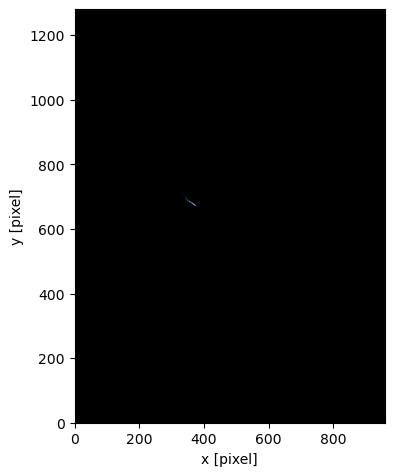

In [25]:
# show image here
# an organism might activate only a few pixels and thus be too small to see
# to check if the organism is there (any pixel values are != 0), go to next cell
vis.generate_image()

In [24]:
# check which pixels are activated by the organism

grid = vis.get_intensity_grid()

if np.any(grid != 0): 
    print('Organism is there!')
else: 
    print('No organism is there.')

Organism is there!


---